# Labor Force Statistics from CPS Microdata

Brian Dew, @bd_econ, brian.w.dew@gmail.com

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

dt = cps_date()
if dt > pd.to_datetime('2022-02-01'):
    pcdt = dt - pd.DateOffset(years=3)
else:
    pcdt = dt - pd.DateOffset(years=2)
def to_date(ym):
    return pd.to_datetime(f'{ym[0]}-{ym[1]}-01')


# Import libraries and adjust settings for map
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize, LinearSegmentedColormap
plt.rc('font', family='Lato')

### LFS by AGE

In [2]:
lfs2 = lambda x: np.where(((x.AGE < 16) | (x.NILFREASON == 'School')), 'Child/Student',
                 np.where(((x.LFS == 'Unemployed') | (x.NILFREASON == 'Discouraged') | 
                           (x.NILFREASON == 'Other')), 'Unemployed/Discouraged/Other',
                 np.where(x.LFS == 'Employed', 'Employed', x.NILFREASON)))

cols = ['YEAR', 'MONTH', 'AGE', 'NILFREASON', 'LFS', 'PWSSWGT']
df = (cps_1mo(cps_dir, dt, cols).assign(LFS2 = lfs2))
df2 = df.copy()
df2.loc[:,'AGE'] = df.AGE + 1
df3 = df.copy()
df3.loc[:,'AGE'] = df.AGE - 1
df = pd.concat([df, df2, df3])
data = (df.groupby(['AGE', 'LFS2']).PWSSWGT.sum().unstack()
          .divide(df.groupby('AGE').PWSSWGT.sum(), axis=0))
data.columns.name = ''
data = data.fillna(0) * 100
data.to_csv(data_dir / 'lfs_age.csv', index_label='AGE')

In [3]:
df = (cps_1mo(cps_dir, pcdt, cols).assign(LFS2 = lfs2))
df2 = df.copy()
df2.loc[:,'AGE'] = df.AGE + 1
df3 = df.copy()
df3.loc[:,'AGE'] = df.AGE - 1
df = pd.concat([df, df2, df3])
data2 = (df.groupby(['AGE', 'LFS2']).PWSSWGT.sum().unstack()
           .divide(df.groupby('AGE').PWSSWGT.sum(), axis=0))
data2.columns.name = ''
data2 = data2.fillna(0) * 100
result = (data - data2).loc[15:].rename({'Child/Student': 'Student'}, axis=1)
result.to_csv(data_dir / 'lfs_age_ch.csv', index_label='AGE')

### Overview data and text

In [4]:
yr_wt = {y: 'PWSSWGT' if y > 1993 else 'BASICWGT' 
         for y in range(1989, 2023)}

cols = ['LFS', 'AGE', 'MONTH', 'YEAR', 'FEMALE']

df = pd.concat([(pd.read_feather(cps_dir / f'cps{y}.ft', 
                                 columns=cols + [w])
                   .rename({w: 'WGT'}, axis=1)) 
                for y, w in yr_wt.items()], sort=False)
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, 
                                 month=df.MONTH, day=1))
data = (df.groupby(['DATE', 'LFS']).WGT.sum()
          .unstack().rename({'nan': 'Children'}, axis=1)
        / 1_000_000)
data.to_csv(data_dir/ 'cps_lfs.csv', index_label='date')

In [5]:
data = pd.read_csv(data_dir/ 'cps_lfs.csv', 
                   index_col='date', parse_dates=True)

datelt = dtxt(data.index[-1])['mon1']
dateltsh = dtxt(data.index[-1])['mon2']
dateyr = dtxt(data.index[-13])['mon1']
dateprepan = dtxt(data.index[-37])['mon1']
dateshprepan = dtxt(data.index[-37])['mon2']
dateyrsh = dtxt(data.index[-13])['mon2']
datepr = f"{dateyr} to {datelt}"
datepr2 = f"{dateprepan} to {datelt}"

write_txt(text_dir / 'cps_lfs_date.txt', datelt)
write_txt(text_dir / 'cps_lfs_datesh.txt', dateltsh)
write_txt(text_dir / 'cps_lfs_dateyr.txt', dateyr)
write_txt(text_dir / 'cps_lfs_datepc.txt', dtxt(pcdt)['mon1'])
write_txt(text_dir / 'cps_lfs_dateprepan.txt', dateprepan)
write_txt(text_dir / 'cps_lfs_dateshprepan.txt', dateshprepan)
write_txt(text_dir / 'cps_lfs_dateyrsh.txt', dateyrsh)
write_txt(text_dir / 'cps_lfs_datepr.txt', datepr)
write_txt(text_dir / 'cps_lfs_date2pr.txt', datepr2)

epop = data["Employed"].iloc[-1] / data.iloc[-1].sum() * 100

In [6]:
text = (f'As of {datelt}, {data["Employed"].iloc[-1]:.1f} '+
        'million people are employed (including self-'+
        'employment). ')
print(text, '\n')
write_txt(text_dir / 'cps_lfs0.txt', text)

text = ('The number of people who are employed divided by '+
        'the total population is the employment rate or '+
        'employment-to-population ratio, which is '+
        f'{epop:.1f} percent as of {datelt}.')
print(text, '\n')
write_txt(text_dir / 'cps_lfs.txt', text)

unemp = (data["Unemployed"].iloc[-1] / 
         (data["Unemployed"].iloc[-1] + 
          data["Employed"].iloc[-1])) * 100
lfpr = ((data["Unemployed"].iloc[-1] + 
         data["Employed"].iloc[-1]) / 
         data.iloc[-1].sum()) * 100

unemptot = data["Unemployed"].iloc[-1]
text = (f'As of {datelt}, there are {unemptot:.1f} million '+
        'unemployed people. The combined group of employed '+
        'and unemployed people is the labor force. The unemployment '+
        'rate, unemployed people as a share of the '+
        'labor force, is '+
        f'currently {unemp:.1f} percent. The '+
        'labor force as a share of the population '+
        'is the labor force participation rate, currently '+
        f'{lfpr:.1f} percent.')
print(text, '\n')
write_txt(text_dir / 'cps_lfs2.txt', text)
    
cols2 = ['LFS', 'AGE', 'MONTH', 'YEAR', 'FEMALE', 
         'NILFREASON', 'PWSSWGT']

v = (cps_1mo(cps_dir, cps_date(), cols2)
     .groupby('NILFREASON').PWSSWGT.sum()
     .divide(1_000_000)
     .apply('({:.1f} million)'.format)
     .str.replace('.0', '', regex=False))

kids = data["Children"].iloc[-1]
nilfpop = data[['NILF', 'Children']].iloc[-1].sum()
text = ('Nonparticipants usually comprise about half '+
        f'of the population, and total {nilfpop:.1f} million '+
        f'in {datelt}. The category includes children '+
        f'({kids:.1f} million), students {v["School"]}, '+
        f'unpaid caregivers {v["Family"]}, those unable to '+
        f'work due to disability or illness {v["Disabled/Ill"]}, '+
        f'those who want a job but have given up looking '+
        f'{v["Discouraged"]}, and retirees and the elderly '+
        f'{v["Retired"]}.')
write_txt(text_dir / 'cps_lfs3.txt', text)
    
data['Total'] = (data[['Employed', 'Unemployed', 'NILF']]
                 .sum(axis=1))
result = data.drop('Children', axis=1).resample('QS').mean()

gc = growth_contrib_ann(result, 'Total').dropna()
gc.to_csv(data_dir / 'cps_lfs2.csv', index_label='date')
print(text)

As of October 2022, 160.5 million people are employed (including self-employment).  

The number of people who are employed divided by the total population is the employment rate or employment-to-population ratio, which is 48.9 percent as of October 2022. 

As of October 2022, there are 5.7 million unemployed people. The combined group of employed and unemployed people is the labor force. The unemployment rate, unemployed people as a share of the labor force, is currently 3.5 percent. The labor force as a share of the population is the labor force participation rate, currently 50.6 percent. 

Nonparticipants usually comprise about half of the population, and total 162.2 million in October 2022. The category includes children (59.5 million), students (18.5 million), unpaid caregivers (12.5 million), those unable to work due to disability or illness (13.8 million), those who want a job but have given up looking (5.4 million), and retirees and the elderly (50.5 million).


### LFS Table

In [7]:
cols = ['LFS', 'BASICWGT', 'AGE', 'MONTH', 'YEAR', 'MJH',
        'FEMALE', 'NILFREASON', 'UNEMPTYPE', 'PTECON', 'WORKFT']

df = cps_1mo(cps_dir, cps_date(), cols).query('AGE > 15')
df2 = cps_1mo(cps_dir, cps_date() - pd.DateOffset(years=3), cols).query('AGE > 15')

age_groups = [(16, 30), (30, 60), (60, 86)]
sex = [0, 1]
d = {'Population': {'query': 'BASICWGT > 0'}, 
     '\hspace{2mm}Employed': {'query': 'LFS == "Employed"'}, 
     '\hspace{4mm}Multiple jobs': {'query': 'MJH == 1'},     
     '\hspace{4mm}Full-time': {'query': 'WORKFT == 1'},  
     '\hspace{4mm}Part-time': {'query': 'WORKFT == 0'}, 
     '\hspace{6mm}Economic reasons': {'query': 'PTECON == 1'},
     '\hspace{2mm}Unemployed': {'query': 'LFS == "Unemployed"'}, 
     '\hspace{2mm}Not in Labor Force': {'query': 'LFS == "NILF"'}, 
     '\hspace{4mm}Discouraged': {'query': 'NILFREASON == "Discouraged"'}, 
     '\hspace{4mm}Disabled/Ill': {'query': 'NILFREASON == "Disabled/Ill"'}, 
     '\hspace{4mm}Family/Care': {'query': 'NILFREASON == "Family"'}, 
     '\hspace{4mm}School': {'query': 'NILFREASON == "School"'}, 
     '\hspace{4mm}Retirement': {'query': 'NILFREASON == "Retired"'}}

d2 = {k: {} for k, v in d.items()}

lf_groups = list(zip(d.keys(), [d[i]['query'] for i in d.keys()])) 

for name, query in lf_groups:
    totval = df.query(query).BASICWGT.sum()/1000
    d[name]['Total, 16+'] = f'{totval:,.0f}'
    chval = totval - df2.query(query).BASICWGT.sum()/1000
    d2[name]['Total, 16+'] = f'{chval:,.0f}'

for sex, (agemin, agemax) in itertools.product(sex, age_groups):
    data = df.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    data2 = df2.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    group = f'{["Women" if sex==1 else "Men"][0]}, {agemin}--{agemax-1}'.replace('--85', '+')
    for name, query in lf_groups:
        tmp = data.query(query).BASICWGT.sum()/1000
        tmp2 = data2.query(query).BASICWGT.sum()/1000
        d[name][group] = f'{tmp:,.0f}'
        d2[name][group] = f'{tmp - tmp2:,.0f}'
        
(pd.DataFrame(d).T.drop('query', axis=1).to_csv(data_dir / 'lfs_table1.tex', 
    sep='&', line_terminator='\\\ ', quotechar=' '))
pd.DataFrame(d2).T.to_csv(data_dir / 'lfs_table2.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

/tmp/ipykernel_25737/3703608409.py:43: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  (pd.DataFrame(d).T.drop('query', axis=1).to_csv(data_dir / 'lfs_table1.tex',
/tmp/ipykernel_25737/3703608409.py:45: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(d2).T.to_csv(data_dir / 'lfs_table2.tex', sep='&', line_terminator='\\\ ', quotechar=' ')


In [8]:
# One year change
cols = ['LFS', 'BASICWGT', 'AGE', 'MONTH', 'YEAR', 'MJH',
        'FEMALE', 'NILFREASON', 'UNEMPTYPE', 'PTECON', 'WORKFT']

df = cps_1mo(cps_dir, cps_date(), cols).query('AGE > 15')
df2 = cps_1mo(cps_dir, cps_date() - pd.DateOffset(years=1), cols).query('AGE > 15')

age_groups = [(16, 30), (30, 60), (60, 86)]
sex = [0, 1]
d = {'Population': {'query': 'BASICWGT > 0'}, 
     '\hspace{2mm}Employed': {'query': 'LFS == "Employed"'}, 
     '\hspace{4mm}Multiple jobs': {'query': 'MJH == 1'},     
     '\hspace{4mm}Full-time': {'query': 'WORKFT == 1'},  
     '\hspace{4mm}Part-time': {'query': 'WORKFT == 0'}, 
     '\hspace{6mm}Economic reasons': {'query': 'PTECON == 1'},
     '\hspace{2mm}Unemployed': {'query': 'LFS == "Unemployed"'}, 
     '\hspace{2mm}Not in Labor Force': {'query': 'LFS == "NILF"'}, 
     '\hspace{4mm}Discouraged': {'query': 'NILFREASON == "Discouraged"'}, 
     '\hspace{4mm}Disabled/Ill': {'query': 'NILFREASON == "Disabled/Ill"'}, 
     '\hspace{4mm}Family/Care': {'query': 'NILFREASON == "Family"'}, 
     '\hspace{4mm}School': {'query': 'NILFREASON == "School"'}, 
     '\hspace{4mm}Retirement': {'query': 'NILFREASON == "Retired"'}}

d2 = {k: {} for k, v in d.items()}

lf_groups = list(zip(d.keys(), [d[i]['query'] for i in d.keys()])) 

for name, query in lf_groups:
    totval = df.query(query).BASICWGT.sum()/1000
    d[name]['Total, 16+'] = f'{totval:,.0f}'
    chval = totval - df2.query(query).BASICWGT.sum()/1000
    d2[name]['Total, 16+'] = f'{chval:,.0f}'

for sex, (agemin, agemax) in itertools.product(sex, age_groups):
    data = df.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    data2 = df2.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    group = f'{["Women" if sex==1 else "Men"][0]}, {agemin}--{agemax-1}'.replace('--85', '+')
    for name, query in lf_groups:
        tmp = data.query(query).BASICWGT.sum()/1000
        tmp2 = data2.query(query).BASICWGT.sum()/1000
        d[name][group] = f'{tmp:,.0f}'
        d2[name][group] = f'{tmp - tmp2:,.0f}'
        
print(datepr)        

October 2021 to October 2022


### Employment rates by age, gender, education

In [9]:
cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'AGE', 'EDUC', 'FEMALE']
df1 = cps_3mo(cps_dir, cps_date() - pd.DateOffset(months=36), cols)
df2 = cps_3mo(cps_dir, cps_date(), cols)

ages = [(16, 19), (20, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
educ = [['LTHS', 'HS'], ['SC'], ['COLL', 'ADV'], ['LTHS', 'HS', 'SC', 'COLL', 'ADV']]
sex = [0, 1]

results = pd.DataFrame()
for a, e, s in itertools.product(ages, educ, sex):
    row_name = f'{a[0]}--{a[1]}'
    col_name = f'{" or ".join(e)} {["Female" if s == 1 else "Male"][0]}'
    for yr, df in [('Year Ago', df1), ('Latest', df2)]:
        data = df.query('@a[0] <= AGE <= @a[1] and EDUC in @e and FEMALE == @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, f'{yr} {col_name}'] = (i.Employed / i.sum()) * 100
        
results.iloc[2:, :-4].to_csv(data_dir / 'empgroups.csv', index_label='name')
results.iloc[:, -4:].to_csv(data_dir / 'empgroups2.csv', index_label='name')

In [10]:
ltdt = dtxt(cps_date())['mon1']
ch = results.iloc[2:, :-4].diff(axis=1)
ch = ch[[col for col in ch.columns if 'Latest' in col]]
inc = (ch>0)
no_ch = (abs(ch) < 2)
nc_sh = no_ch[no_ch==True].count(axis=0).sum() / no_ch.count().sum()
inc = ch > 2
i_sh = inc[inc==True].count(axis=0).sum() / inc.count().sum()
dec = ch < -2
d_sh = dec[dec==True].count(axis=0).sum() / dec.count().sum()
ch_txt = ('about the same as' if nc_sh >= 0.5 else 'higher than' 
          if i_sh >= 0.5 else 'lower than' if d_sh >= 0.5 
          else 'different than')
text = ('Employment rates vary over time, but also by age, gender, '+
        'and education, among other factors. Over the three months '+
        f'ending {ltdt}, the employment rate for most subgroups '+
        f'is {ch_txt} it was before the pandemic. At a given '+
        'point in time, employment rates tend to increase with education '+
        'and tend to peak during ages 25 to 54. Within most age groups, '+
        'employment rates are higher for men, though the gap has narrowed '+
        'over the long-run.')
write_txt(text_dir / 'empgroups.txt', text)
print(text)

Employment rates vary over time, but also by age, gender, and education, among other factors. Over the three months ending October 2022, the employment rate for most subgroups is about the same as it was before the pandemic. At a given point in time, employment rates tend to increase with education and tend to peak during ages 25 to 54. Within most age groups, employment rates are higher for men, though the gap has narrowed over the long-run.


### Union Membership

In [11]:
unmem = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT']) * 100
uncov = lambda x: np.average(x['UNION'], weights=x['PWORWGT']) * 100

columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNION', 'UNIONMEM', 'INDGRP']
df = (pd.concat([(pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
        .query('LFS == "Employed" and UNION in [0, 1]')) 
                 for year in range(1989, 2023)]))
# Industry membership rate data
ind = (df.groupby(['YEAR', 'MONTH', 'INDGRP']).apply(unmem)).unstack()

# Overall rate and levels data
grp = df.groupby(['YEAR', 'MONTH'])
data = pd.DataFrame({'Membership': grp.apply(unmem),
                     'Coverage': grp.apply(uncov),
                     'Union': (df.query('UNIONMEM == 1')
                                 .groupby(['YEAR', 'MONTH']).PWORWGT.sum()
                               / 1_000_000),
                     'Covered': (df.query('UNION == 1')
                                 .groupby(['YEAR', 'MONTH']).PWORWGT.sum()
                               / 1_000_000),
                     'CovNM': (df.query('UNION == 1 and UNIONMEM == 0')
                                 .groupby(['YEAR', 'MONTH']).PWORWGT.sum()
                               / 1_000_000),
                     'Nonunion': (df.query('UNIONMEM == 0')
                                    .groupby(['YEAR', 'MONTH']).PWORWGT.sum()
                                  / 1_000_000)})

data = pd.concat([ind, data], axis=1)
data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data.index]
data.to_csv(text_dir / 'union_raw.csv', index_label='date')

In [12]:
data = pd.read_csv(text_dir / 'union_raw.csv', index_col='date', 
                   parse_dates=True)
data['Diff'] = data['Coverage'] - data['Membership']
d12 = data.rolling(12).mean()
cats = ['Nonunion', 'Covered']
l12 = d12[cats]
yrch = (l12.iloc[-1] - l12.iloc[-13])
ltdt = dtxt(data.index[-1])['mon1']
yrdt = dtxt(data.index[-13])['mon1']
cbm = c_box('violet')
cbc = c_box('magenta')
non = value_text(yrch['Nonunion'], 'increase_by', ptype='million')
cov = value_text((yrch['Covered'] * 1_000_000).round(-3), 'increase_by', 
                 ptype=None, digits=0)
text = (f'Over the 12 months ending {ltdt}, the union membership rate '+
        f'averaged {d12.Membership.iloc[-1]:.1f} percent {cbm}. The coverage '+
        'rate, which includes nonmembers that are covered under a union '+
        f'contract, was {d12.Coverage.iloc[-1]:.1f} percent. During '+
        f'the 12-month period, an average of {d12.Nonunion.iloc[-1]:.1f} '+
        f'million workers were not represented by a union, '+
        f'{d12.Union.iloc[-1]:.1f} million workers were union members, '+
        f'and an additional {d12.CovNM.iloc[-1]:.1f} million workers, '+
        f'or {d12.Diff.iloc[-1]:.1f} percent of the workforce, reported '
        f'no union affiliation but were covered by a union contract {cbc}. '+
        '\n\n One year prior, over the 12 months ending '+
        f'{yrdt}, the union membership rate was {d12.Membership.iloc[-13]:.1f} '+
        f'percent, and the coverage rate was {d12.Coverage.iloc[-13]:.1f} '+
        f'percent. From {yrdt} to {ltdt}, the 12-month average number of '+ 
        f'nonunion workers {non}, while the number of workers represented '+
        f'by unions {cov}.')
write_txt(text_dir / 'union.txt', text)
print(text)

cols = ['Membership', 'Diff']
sdf = d12[cols].iloc[-1]
height = ((sdf.cumsum() - (sdf / 2) + 1.0)).to_dict()
val = sdf.to_dict()
dtp = dtxt(d12.index[-1] + pd.DateOffset(months=2))['datetime']
nodes = [f'\\absnode{{{{{dtp}}}}}{{{height[i]}}}{{\scriptsize {val[i]:.1f}\%}}' 
         for i in cols]
dtv = dtxt(d12.index[-1])['mon2'].replace(' ', '\\\\ \scriptsize ')
dtn = f'\\absnode{{{{{dtp}}}}}{{{sdf.cumsum().iloc[-1] + 5.0}}}{{\scriptsize {dtv}:}}'
nodes.append(dtn)
nodetext = '\n'.join(nodes)
write_txt(text_dir / 'union_nodes.txt', nodetext)

Over the 12 months ending October 2022, the union membership rate averaged 10.1 percent (see \cbox{violet}). The coverage rate, which includes nonmembers that are covered under a union contract, was 11.4 percent. During the 12-month period, an average of 127.0 million workers were not represented by a union, 14.3 million workers were union members, and an additional 1.8 million workers, or 1.3 percent of the workforce, reported no union affiliation but were covered by a union contract (see \cbox{magenta}). 

 One year prior, over the 12 months ending October 2021, the union membership rate was 10.3 percent, and the coverage rate was 11.6 percent. From October 2021 to October 2022, the 12-month average number of nonunion workers increased by 5.4 million, while the number of workers represented by unions increased by 322,000.


In [13]:
data = pd.read_csv(text_dir / 'union_raw.csv', index_col='date', 
                   parse_dates=True)
dropcats = ['Membership', 'Coverage', 'Union', 'Covered', 
            'CovNM', 'Nonunion']
data = data.drop(dropcats, axis=1)
prev12 = data.iloc[-13]
lval = data.iloc[-1]
minval = data.min()
maxval = data.max()
width = maxval - minval
final = pd.concat([lval, prev12, minval, maxval, width], axis=1)
final.columns = ['latest', 'prev12', 'min', 'max', 'width']
final.index.name = 'name'
final = final[['min', 'width', 'latest', 'prev12']].sort_values('latest', ascending=False)
final['y'] = [0.13, -0.87, -1.87, -2.87, -3.87, -4.87, -5.87]
final.to_csv(data_dir / 'union_ind.csv', sep=';')

dt1, dt2 = dtxt(data.index[-1])['mon2'], dtxt(data.index[-13])['mon2']
write_txt(text_dir / 'union_ltdt.txt', dt1)
write_txt(text_dir / 'union_yrdt.txt', dt2)

dec = (maxval - lval).sort_values()
dec1 = dec.index[-1]
decval1 = dec[-1]
decmaxdt = dtxt(data[dec1].idxmax())['mon1']
decmaxval = data[dec1].max()
decgrp = dec1.lower()
lowgroupmaxdt = dtxt(data[final.index[-1]].idxmax())['mon1']
lowgrp = final.index[-1].lower()


text = (f'{final.index[0]} has the highest union membership rate, '+
        f'at {final.latest.iloc[0]:.1f} percent as of {ltdt}, followed by '+
        f'{final.index[1].lower()} with {final.latest.iloc[1]:.1f} percent, '+
        f'and {final.index[2].lower()} with {final.latest.iloc[2]:.1f} percent. '+
        f'\n\nThe {decgrp} industry '+
        'experienced the largest overall percentage point decrease '+
        'in union membership rates over the past 30 years, and is '+
        f'currently {decval1:.1f} percentage points below its {decmaxdt} '+
        f'rate of {decmaxval:.1f} percent.\n\n')
txt2 = ('The lowest union membership rate '+
        f'is in {lowgrp} ({final.latest.iloc[-1]:.1f} percent). '+
        f'The union membership rate of the industry was {data[final.index[-1]].max():.1f} '+
        f'percent at its 30-year peak in {lowgroupmaxdt}. ')

mfglt = data['Manufacturing'].iloc[-1]
mfgpr = data['Manufacturing'].iloc[-13]
prdt = dtxt(data.index[-13])['mon1']
mfgpr2 = data['Manufacturing'].iloc[-37]
prdt2 = dtxt(data.index[-37])['mon1']

txt3 = (f'The manufacturing industry union membership rate was {mfglt:.1f} '+
        f'percent in {ltdt}, {mfgpr:.1f} percent in {prdt}, and {mfgpr2:.1f} '+
        f'percent in {prdt2}.')

if lowgrp == decgrp:
    text = text + txt3
else:
    text = text + txt2

write_txt(text_dir / 'union_ind.txt', text)
print(text)

Public administration has the highest union membership rate, at 28.7 percent as of October 2022, followed by education and health with 16.6 percent, and construction and mining with 9.8 percent. 

The manufacturing industry experienced the largest overall percentage point decrease in union membership rates over the past 30 years, and is currently 16.8 percentage points below its February 1989 rate of 23.5 percent.

The lowest union membership rate is in leisure and hospitality (2.9 percent). The union membership rate of the industry was 18.0 percent at its 30-year peak in January 1989. 


### Matching YY -- Disability to Work Flows

In [14]:
# Calculate monthly rate and store as raw file
cols = ['CPSID', 'AGE', 'FEMALE', 'WBHAO', 'NILFREASON', 
        'LFS', 'MIS', 'BASICWGT', 'LINENO']
emp = lambda x: np.where(x.LFS_y == 'Employed', 1, 0)
dates = pd.date_range('1997-01-01', cps_date(), freq='MS')
d = {}
for dt in dates:
    df1 = (cps_1mo(cps_dir, dt - pd.DateOffset(years=1), cols)
           .query('NILFREASON == "Disabled/Ill"'))
    df2 = cps_1mo(cps_dir, dt, cols)
    data = (pd.merge(df1, df2, on=['CPSID', 'LINENO', 'FEMALE', 
                                   'WBHAO'])
              .query('25 <= AGE_y <= 54'))
    data = ((data.loc[(data.AGE_x <= data.AGE_y) & 
                      (data.AGE_y - 2 <= data.AGE_x)])
                 .assign(EMP = emp))
    d[dt] = np.average(data.EMP, weights=data.BASICWGT_y) * 100
s = pd.Series(d).rename('Share')
s.to_csv(data_dir / 'disflow_raw.csv', index_label='date', 
         header=True)

In [15]:
s = pd.read_csv(data_dir / 'disflow_raw.csv', 
                index_col='date', parse_dates=True)
df = s.rolling(12).mean().dropna()['Share']
df.to_csv(data_dir / 'disflow.csv', index_label='date', 
          header=True)
color = 'blue'
node = end_node(df, color, date='m', percent=True, 
                offset=True, size=1.2)
write_txt(text_dir/ 'disflow_node.txt', node)

latest = df.iloc[-1]
valavg = df.loc['2010-12-01':'2013-12-01'].mean()
val19 = df.loc['2019'].mean()
ltdate = dtxt(df.index[-1])['mon1']

text = (f'Over the year ending {ltdate}, {latest:.1f} '+
        'percent of 25 to 54 year olds who were out of '+
        'the labor force due to disability or illness '+
        f'one year prior became employed {c_line(color)}. '+
        f'Pre-pandemic, in 2019, {val19:.1f} percent of '+
        'those in the category found a job. '+
        'The one-year rate of job-finding has increased '+
        'substantially from its 2010--2013 average of '+
        f'{valavg:.1f} percent.')
write_txt(text_dir / 'disflow.txt', text)
print(text)

Over the year ending October 2022, 9.6 percent of 25 to 54 year olds who were out of the labor force due to disability or illness one year prior became employed (see {\color{blue}\textbf{---}}). Pre-pandemic, in 2019, 8.0 percent of those in the category found a job. The one-year rate of job-finding has increased substantially from its 2010--2013 average of 5.8 percent.


### Job switching rate

In [16]:
cols = ['YEAR', 'MONTH', 'SAMEEMP', 'BASICWGT', 'LFS']
df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                  .query('LFS == "Employed" and SAMEEMP in [0, 1]') 
                for year in range(1994, 2023)])
newemp = (lambda x: x.query('SAMEEMP == 0').BASICWGT.sum()
                 / x.BASICWGT.sum())

data = (df.groupby(['YEAR', 'MONTH']).apply(newemp)).reset_index()
data['date'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))
data = data.set_index('date').drop(['YEAR', 'MONTH'], axis=1) * 100
sm = x13_arima_analysis(data)
res = pd.concat([sm.seasadj.rename('Monthly'), 
           sm.seasadj.rolling(3).mean().rename('MA3')], axis=1)
res.to_csv(data_dir / 'jobswitch.csv', index_label='date')

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [17]:
res = pd.read_csv(data_dir / 'jobswitch.csv', index_col='date', 
                  parse_dates=True)
qcol = 'blue!80!black'
mcol = 'green!90!blue'
node = end_node(res['Monthly'], mcol, date='m', percent=True)
write_txt(text_dir/ 'jobswitch_node.txt', node)
ltdate = dtxt(res.index[-1])['mon1']
ltval = f'{res["Monthly"].iloc[-1]:.1f} percent'
ltqval = f'{res["MA3"].iloc[-1]:.1f} percent'
also = 'also ' if ltval == ltqval else ''
ltq = f'the three months ending {ltdate}'
pcdate = '2019-12-01'
pcqval = f'{res["MA3"].loc[pcdate]:.1f} percent'
text = ('More recent data show a slight increase in job switching rates. '+
        f'In {ltdate}, {ltval} of the workforce had a '+
        'different employer than the previous month, after seasonal '+
        f'adjustment {c_line(mcol)}. Smoothed data {also}show an average '+
        f'of {ltqval} of the workforce with a new employer during {ltq} '+
        f'{c_line(qcol)}. Prior to COVID-19, in {dtxt(pcdate)["qtr1"]}, '+
        f'a monthly average of {pcqval} of the workforce switched jobs.')
write_txt(text_dir / 'jobswitch.txt', text)
print(text)

More recent data show a slight increase in job switching rates. In October 2022, 2.4 percent of the workforce had a different employer than the previous month, after seasonal adjustment (see {\color{green!90!blue}\textbf{---}}). Smoothed data show an average of 2.5 percent of the workforce with a new employer during the three months ending October 2022 (see {\color{blue!80!black}\textbf{---}}). Prior to COVID-19, in 2019 Q4, a monthly average of 2.2 percent of the workforce switched jobs.


### Young adults school/NILF

In [18]:
sch_stat = lambda x: np.where(x.NILFREASON == 'School', 'School',
                     np.where(x.LFS == 'NILF', 'Other', 'LF'))
age_grp = lambda x: np.where(x.AGE < 22, '19-21', '22-24')
date = lambda x: pd.to_datetime(dict(year=x.YEAR, month=x.MONTH, day=1))

datecol = ['YEAR', 'MONTH']
cols = ['AGE', 'NILFREASON', 'BASICWGT', 'LFS'] + datecol

df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                  .query('18 < AGE < 25').assign(SCH_STAT = sch_stat, 
                                                 AGE_GRP = age_grp,
                                                 DATE = date) 
                for year in range(1994, 2023)])

res = pd.DataFrame()
for ag in ['19-21', '22-24']:
    td = df.query('AGE_GRP == @ag')
    data = ((td.groupby(['DATE', 'SCH_STAT']).BASICWGT.sum() / 
             td.groupby('DATE').BASICWGT.sum()) * 100).unstack()
    data.columns = [i + '_' + ag for i in data.columns]
    data.columns.name = ''
    data['Total_' + ag] = 100 - data['LF_' + ag]
    data = data.drop('LF_' + ag, axis=1)
    res = res.join(data, how='right')
    
ma = res.rolling(12).mean().dropna()
ma.to_csv(data_dir/ 'young_school.csv', index_label='date')

colors = [('School_', 'blue!50!cyan'),
          ('Other_', 'violet!85!black')]

for ag in ['19-21', '22-24']:
    node_dt = None if ag == '22-24' else 'm'
    nodeadj = 0 if ag == '22-24' else -0.25
    node = end_node(ma['Total_' + ag], 'orange!90!yellow', percent=True,
                    date=node_dt, offset=nodeadj, full_year=True)
    nodes = '\n'.join([node] + [end_node(ma[name + ag], color, percent=True) 
                       for name, color in colors])
    write_txt(text_dir/ f'young_nilf{ag}_node.txt', nodes)
    
t0019 = f'{ma.loc["2000-12-01", "Total_19-21"]:.1f}'
t0022 = f'{ma.loc["2000-12-01", "Total_22-24"]:.1f}'
t1119 = f'{ma.loc["2014-12-01", "Total_19-21"]:.1f}'
t1122 = f'{ma.loc["2014-12-01", "Total_22-24"]:.1f}'
t1919 = f'{ma.loc["2020-02-01", "Total_19-21"]:.1f}'
t1922 = f'{ma.loc["2020-02-01", "Total_22-24"]:.1f}'
tlt19 = f'{ma.loc[cps_date(), "Total_19-21"]:.1f}'
tlt22 = f'{ma.loc[cps_date(), "Total_22-24"]:.1f}'
ltdate = dtxt(cps_date())['mon1']    
text = ('From 1994 to 2000, labor force participation among young people '+
        'increased slightly. Following the recession of 2001, and carrying '+
        'through the great recession, participation rates dropped sharply. '+
        'From 2000 to 2014, labor force non-participation increased '+
        f'from {t0019} percent to {t1119} percent for 19 to 21 year olds '+
        f'and from {t0022} percent to {t1122} percent for 22 to 24 year olds '+
        '(see {\color{orange!90!yellow}\\textbf{---}}). The overall '+
        'increase is nearly entirely accounted for by increased college '+
        'enrollment (see {\color{blue!50!cyan}\\textbf{---}}).\n\nBy February '+
        '2020, the labor market had improved and the annual non-participation '+
        f'rate was {t1919} percent for 19 to 21 year olds and {t1922} '+
        f'percent for 22 to 24 year olds. In the latest data, covering the '+
        f'12 months ending {ltdate}, the rate of non-participation is {tlt19} '+
        f'percent for 19 to 21 year olds and {tlt22} percent for 22 to 24 '+
        'year olds. ')
write_txt(text_dir / 'young_nilf.txt', text)
print(text)

From 1994 to 2000, labor force participation among young people increased slightly. Following the recession of 2001, and carrying through the great recession, participation rates dropped sharply. From 2000 to 2014, labor force non-participation increased from 28.2 percent to 39.3 percent for 19 to 21 year olds and from 19.3 percent to 24.6 percent for 22 to 24 year olds (see {\color{orange!90!yellow}\textbf{---}}). The overall increase is nearly entirely accounted for by increased college enrollment (see {\color{blue!50!cyan}\textbf{---}}).

By February 2020, the labor market had improved and the annual non-participation rate was 38.3 percent for 19 to 21 year olds and 22.9 percent for 22 to 24 year olds. In the latest data, covering the 12 months ending October 2022, the rate of non-participation is 39.0 percent for 19 to 21 year olds and 24.1 percent for 22 to 24 year olds. 


### CPS Labor Force Nonparticipation by Reason

Replication using python of a very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

In [19]:
years = range(2000, 2023)
ref_pd = (2001, 3)
ref_dt = to_date(ref_pd)
ages = '18 <= AGE <= 64'
wgt = 'BASICWGT'
cat = 'NILFREASON'
dates = ['YEAR', 'MONTH']
dems = ['FEMALE', 'AGE']
cols = dates + dems + [wgt, cat]
files = [f'cps{year}.ft' for year in years]

# CPS Data
df = pd.concat([pd.read_feather(cps_dir / file, columns=cols)
                  .query(ages) for file in files])

p = df.groupby(dates + dems)[wgt].sum().rename('ADJ')
sh = (p / p.groupby(dates).sum())
adj = (sh.loc[ref_pd] / sh).reset_index()
data = (pd.merge(df, adj)
          .assign(ADJWGT = lambda x: x.ADJ * x[wgt]))
data.NILFREASON.cat.rename_categories({'nan': 'LF'}, 
                                      inplace=True)

# Make Adjustments
c = data.groupby(dates + [cat]).ADJWGT.sum()
dem_res = (c / c.groupby(dates).sum()).unstack()
dem_res.columns = dem_res.columns.to_list()

c_nd = data.groupby(dates + [cat])[wgt].sum()
nd_res = (c_nd / c_nd.groupby(dates).sum()).unstack()

dem_res['Demographics'] = dem_res['LF'] - nd_res['LF']
dem_res.index = [to_date(ym) for ym in dem_res.index]

keep_cols = dem_res.columns.difference(['LF'])
result = (dem_res.rolling(12).mean().dropna()
                 .loc[ref_dt:, keep_cols] * 100)

final = result.iloc[0] - result
final.to_csv(data_dir / 'nilf.csv', index_label='date')

/tmp/ipykernel_25737/724010234.py:21: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  data.NILFREASON.cat.rename_categories({'nan': 'LF'},


In [20]:
final = pd.read_csv(data_dir / 'nilf.csv', index_col='date', 
                    parse_dates=True)
colors = {'Disabled/Ill': 'green!80!blue', 
          'Discouraged': 'blue', 
          'Family': 'red', 
          'Retired': 'orange', 
          'School': 'cyan', 
          'Demographics': 'violet!80!purple'}

adj = node_adj(final)
node_file = open(text_dir / 'nilf_nodes.txt', 'w')
for series, color in colors.items():
    if series in adj.keys():
        offset = adj[series] / 2
    else:
        offset = 0
    node_file.write(end_node(final[series], color, 
                             size=1.2, offset=offset))
node_file.close()

ltdate = dtxt(cps_date())['mon1']
lt = final.iloc[-1]
tot = abs(lt.sum())
dem = abs(lt['Demographics'])
demc = c_line(colors['Demographics'])
sch = abs(lt['School'])
schc = c_line(colors['School'])
dis = abs(lt['Disabled/Ill'])
disc = c_line(colors['Disabled/Ill'])
ret = abs(lt['Retired'])
retc = c_line(colors['Retired'])

text = (f'From March 2001 to the latest available twelve months '+
        f'of data, ending {ltdate}, an additional {tot:.1f} percent '+
         'of the age 18 to 64 population left the labor force. Changes '+
         'in the demographic composition of the population affect the '+
         'rate of participation. For example, the larger-than-normal '+
         'population cohort born after World War II is reaching '+
         'retirement age in this period. Changes in the age and '+
        f'sex distribution within the age group explain {dem:.1f} '+
        f'percentage points of the cumulative decrease in participation '+ 
        f'since March 2001 {demc}. \n\nAdditionally, young people are '+
        f'staying in school longer, on average, reducing the age 18 to 64 '+
        f'labor force by {sch:.1f} percent {schc}. Disability and '+
        f'illness reduce the labor force by another {dis:.1f} percent '+
        f'{disc}. Less retirement among those age 18 to 64 increases the '+
        f'labor force by {ret:.1f} percent, over the period {retc}.')
write_txt(text_dir / 'nilf_01.txt', text)
print(text)

From March 2001 to the latest available twelve months of data, ending October 2022, an additional 2.7 percent of the age 18 to 64 population left the labor force. Changes in the demographic composition of the population affect the rate of participation. For example, the larger-than-normal population cohort born after World War II is reaching retirement age in this period. Changes in the age and sex distribution within the age group explain 1.1 percentage points of the cumulative decrease in participation since March 2001 (see {\color{violet!80!purple}\textbf{---}}). 

Additionally, young people are staying in school longer, on average, reducing the age 18 to 64 labor force by 1.6 percent (see {\color{cyan}\textbf{---}}). Disability and illness reduce the labor force by another 0.5 percent (see {\color{green!80!blue}\textbf{---}}). Less retirement among those age 18 to 64 increases the labor force by 0.7 percent, over the period (see {\color{orange}\textbf{---}}).


In [21]:
text = (f'Since March 2001, 2.9 percent of those age 18 to 64 have '+
        f'left the labor force. Part of this change, 1.1 percentage '+
        'points, is explained by demographic changes in the age '+
        'and sex distribution of the group.\n\nIncreased school and college '+
        'enrollment reduces age 18 to 64 participation by an '+
        'additional 1.6 percentage points, relative to March 2001. '+
        'Higher disability and illness rates reduce the age group labor force '+
        'by 0.6 percent. Less retirement increases the age group labor force by 0.7 percent.')
print(text)

Since March 2001, 2.9 percent of those age 18 to 64 have left the labor force. Part of this change, 1.1 percentage points, is explained by demographic changes in the age and sex distribution of the group.

Increased school and college enrollment reduces age 18 to 64 participation by an additional 1.6 percentage points, relative to March 2001. Higher disability and illness rates reduce the age group labor force by 0.6 percent. Less retirement increases the age group labor force by 0.7 percent.


In [22]:
# Bar chart with NILF categories latest and pre-COVID
result, share = pd.DataFrame(), pd.DataFrame()
dts = [cps_date(), cps_date() - pd.DateOffset(years=3)]
for i, date in enumerate(dts):
    m = cps_1mo(cps_dir, date, cols + ['PWSSWGT']).query('AGE > 15')
    dt = dtxt(date)['mon1']
    result[dt] = m.groupby('NILFREASON').PWSSWGT.sum()
    share[dt] = result[dt] / result[dt].sum() * 100
    write_txt(text_dir / f'nilf_mo{i+1}.txt', dtxt(date)['mon2'])
    
(share.drop('nan').sort_values(share.columns[0], ascending=False)
 .round(1).to_csv(data_dir / 'nilf_comp.csv', index_label='name'))

sh = share.applymap('{:.1f} percent'.format)
res = result.applymap(lambda x: f'{x / 1_000_000:.1f} million')
mo1, mo2 = sh.columns
totlt = result[mo1].drop('nan').sum() / 1_000_000
totsh = share[mo1].drop('nan').sum()
shpr = share[mo2].drop('nan').sum()

color = 'green!80!blue!72!black'
color2 = 'green!80!blue!60!lime'

ret = 'Retired'
di = 'Disabled/Ill'
fm = 'Family'
sc = 'School'

text = (f'Nonparticipants age 16 and older total {totlt:.1f} '+
        f'million in {mo1}, and make up {totsh:.1f} percent of the '+
        f'age 16 or older population, compared to {shpr:.1f} '+
        f'percent in {mo2}. About half of nonparticipants, and '+
        f'{sh.loc[ret, mo1]} of the population, are '+
        f'retirees in {mo1} {c_box(color)}, compared to '+
        f'{sh.loc[ret, mo2]} in '+
        f'{mo2} {c_box(color2)}.\n\nDisability or illness keeps an '+
        f'additional {sh.loc[di, mo1]} '+
        f'out of the labor force in {mo1}, compared to '+
        f'{sh.loc[di, mo2]} in {mo2}. Students who are out of the '+
        f'labor force make up {sh.loc[sc, mo1]} '+
        f'in {mo1} and {sh.loc[sc, mo2]} in {mo2}, '+
        f'while unpaid caregivers are {sh.loc[fm, mo1]} in {mo1} and '+
        f'{sh.loc[fm, mo2]} in {mo2}.')
write_txt(text_dir / 'nilfbasic.txt', text)
print(text)

Nonparticipants age 16 and older total 98.7 million in October 2022, and make up 37.3 percent of the age 16 or older population, compared to 36.2 percent in October 2019. About half of nonparticipants, and 19.1 percent of the population, are retirees in October 2022 (see \cbox{green!80!blue!72!black}), compared to 18.2 percent in October 2019 (see \cbox{green!80!blue!60!lime}).

Disability or illness keeps an additional 5.2 percent out of the labor force in October 2022, compared to 5.4 percent in October 2019. Students who are out of the labor force make up 5.6 percent in October 2022 and 5.7 percent in October 2019, while unpaid caregivers are 4.7 percent in October 2022 and 4.7 percent in October 2019.


### Occupations

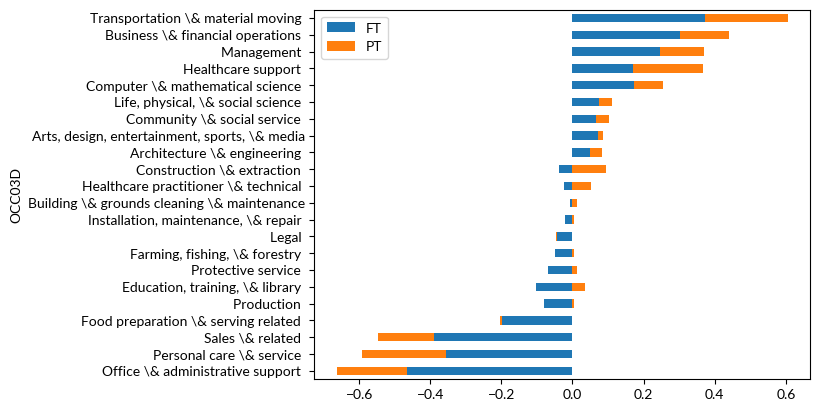

In [23]:
occs = {1   :  'Management occupations',
        2   :  'Business and financial operations occupations',
        3   :  'Computer and mathematical science occupations',
        4   :  'Architecture and engineering occupations',
        5   :  'Life, physical, and social science occupations',
        6   :  'Community and social service occupations',
        7   :  'Legal occupations',
        8   :  'Education, training, and library occupations',
        9   :  'Arts, design, entertainment, sports, and media',
        10  :  'Healthcare practitioner and technical occupations',
        11  :  'Healthcare support occupations',
        12  :  'Protective service occupations',
        13  :  'Food preparation and serving related occupations',
        14  :  'Building and grounds cleaning and maintenance',
        15  :  'Personal care and service occupations',
        16  :  'Sales and related occupations',
        17  :  'Office and administrative support occupations',
        18  :  'Farming, fishing, and forestry occupations',
        19  :  'Construction and extraction occupations',
        20  :  'Installation, maintenance, and repair occupations',
        21  :  'Production occupations',
        22  :  'Transportation and material moving occupations'}

cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'OCC03D', 'OCC203D', 'WORKFT', 'COW1', 'COW2']

df = cps_3mo(cps_dir, cps_date(), cols)
df2 = cps_3mo(cps_dir, cps_date() - pd.DateOffset(months=36), cols)

df['OCC03D'] = df['OCC03D'].map(occs)
df2['OCC03D'] = df2['OCC03D'].map(occs)

data = pd.DataFrame()

data['FT'] = (((df.query('WORKFT == 1').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum()) - 
              (df2.query('WORKFT == 1').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum())) * 100)
data['PT'] = (((df.query('WORKFT == 0').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum()) - 
              (df2.query('WORKFT == 0').groupby('OCC03D').PWSSWGT.sum() / df.PWSSWGT.sum())) * 100)
data['Total'] = data.sum(axis=1)

data.index = data.index.str.replace('occupations', '').str.replace('and', '\&')

data = data.sort_values('Total')
data.drop('Total', axis=1).to_csv(data_dir / 'occs.csv', sep=';', index_label='name', header=True)

data.drop('Total', axis=1).plot(kind='barh', stacked=True);

data1 = data.drop('Total', axis=1)

### Atlanta Fed WGT

In [24]:
cols = ['AGE', 'HRWAGE', 'ATLFLG', 'FEMALE', 'CPSID', 'WBHAO', 
        'LINENO', 'WKEARN']
mergecol = ['CPSID', 'LINENO', 'FEMALE', 'WBHAO']
filters = 'HRWAGE >= 2.13 and ATLFLG == 1'
dates = pd.date_range('1997-01-01', cps_date(), freq='MS')
d, d2, d3 = {}, {}, {}
for dt in dates:
    df1 = cps_1mo(cps_dir, dt - pd.DateOffset(years=1), 
                  cols).query(filters)
    df2 = cps_1mo(cps_dir, dt, cols).query(filters)
    data = (pd.merge(df1, df2, on=mergecol))
    data = (data.loc[(data.AGE_x <= data.AGE_y) & 
                     (data.AGE_y - 2 <= data.AGE_x)])
    wage_change_array = ((data['HRWAGE_y'] / data['HRWAGE_x']) - 1) * 100
    wkpy_change_array = ((data['WKEARN_y'] / data['WKEARN_x']) - 1) * 100
    d[dt] = wage_change_array.median()
    d3[dt] = wkpy_change_array.median()
    zwc = (len(wage_change_array[(wage_change_array >= -0.5) & 
                                 (wage_change_array <= 0.5)]) / 
           len(wage_change_array)) * 100
    d2[dt] = zwc

result = pd.Series(d, name='bd_cps').to_frame()
result['3ma'] = result.rolling(3).mean()
result['wk'] = pd.Series(d3, name='wkpy').to_frame()
result['wk3ma'] = result['wk'].rolling(3).mean()
result['zwc'] = pd.Series(d2).rolling(3).mean()
result.to_csv(data_dir/ 'atl_wgt.csv', index_label='date')

In [25]:
df = pd.read_csv(data_dir / 'atl_wgt.csv', 
                 index_col='date', parse_dates=True)
ltdt = dtxt(df.index[-1])['mon1']
ltval = df['bd_cps'].iloc[-1]
lt3m = df['3ma'].iloc[-1]
yrdt = dtxt(df.index[-13])['mon1']
pr3m = df['3ma'].iloc[-13]
also = 'also' if round(lt3m) == round(pr3m) else ''

col = 'orange!60!white'
col3 = 'blue!75!cyan'
wval = value_text(df.wk.iloc[-1])
text = ('Replication of the wage growth tracker '+
        'shows matched-observation hourly wage '+
        f'growth of {ltval:.1f} percent in {ltdt} {c_line(col)}, '+
        f'and average wage growth of {lt3m:.1f} percent over '+
        f'the three months ending {ltdt} {c_line(col3)}. '+
        f'One year prior, in {yrdt}, three-month moving average '+
        f'wage growth was {also}{pr3m:.1f} percent. Matched '+
        'observation weekly wage growth, which is affected '+
        f'by changes in hours worked, {wval} over the year '+
        f'ending {ltdt} (see right chart).')
write_txt(text_dir / 'atl_wgt.txt', text)
print(text)

ltval = df['zwc'].iloc[-1]
prval = df['zwc'].iloc[-2]
prdate = dtxt(df.index[-2])['mon1']
yrval = df['zwc'].iloc[-13]

zcol = 'red'
node = end_node(df['zwc'], zcol, date='m', 
                full_year=True, percent=True)
write_txt(text_dir/ 'zwc_node.txt', node)

text = (f'In {ltdt}, {ltval:.1f} '+
        'percent of individuals had no hourly wage growth, '+
        f'compared to {prval:.1f} in {prdate} {c_line(zcol)}. '+
        f'One year prior, in {yrdt}, {yrval:.1f} percent of '+
        'individuals had no wage growth.')
write_txt(text_dir / 'atl_zwc.txt', text)
print(text)

Replication of the wage growth tracker shows matched-observation hourly wage growth of 6.5 percent in October 2022 (see {\color{orange!60!white}\textbf{---}}), and average wage growth of 6.7 percent over the three months ending October 2022 (see {\color{blue!75!cyan}\textbf{---}}). One year prior, in October 2021, three-month moving average wage growth was 4.4 percent. Matched observation weekly wage growth, which is affected by changes in hours worked, increased 5.7 percent over the year ending October 2022 (see right chart).
In October 2022, 11.8 percent of individuals had no hourly wage growth, compared to 11.8 in September 2022 (see {\color{red}\textbf{---}}). One year prior, in October 2021, 13.3 percent of individuals had no wage growth.


### Unemployment Rate for Smaller Groups

In [26]:
cols = ['YEAR', 'MONTH', 'WBHAOM', 'BASICWGT', 'LFS', 'AGE', 'FEMALE']
groups = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'More than one']

unrate = lambda x: np.average(x['UNEMP'], weights=x['BASICWGT']) * 100
unsh = lambda x: (x['UNEMP'] * x['BASICWGT']).sum()
unemp = lambda x: np.where(x['LFS'] == 'Unemployed', 1, 
                  np.where(x['LFS'] == 'Employed', 0, np.nan))


df, df2, df3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for dt in [cps_date(), cps_date() - pd.DateOffset(months=36)]:
    data = (cps_6mo(cps_dt=pd.to_datetime(dt), cols=cols, cps_dir=cps_dir)
            .assign(UNEMP = unemp)
            .query('AGE > 15 and AGE < 65 and LFS != "NILF"'))
    
    srs = data.groupby('WBHAOM').apply(unrate)
    df[dtxt(dt)['mon2']] = srs.loc[groups]
    
    unemptot = (data['UNEMP'] * data['BASICWGT']).sum()
    srs2 = (data.groupby('WBHAOM').apply(unsh) / unemptot) * 100
    df2[dtxt(dt)['mon2']] = srs2.loc[groups]
    pop = data.BASICWGT.sum()
    popsh = (data.groupby('WBHAOM').BASICWGT.sum() / pop) * 100
    df3[dtxt(dt)['mon2']] = popsh.loc[groups]

df.index.name = ''
df.to_csv(data_dir / 'unemp_grp.csv', index_label='name', header=True)
df2.index.name = ''
df2['pop'] = df3.mean(axis=1)
df2.to_csv(data_dir / 'unemp_grpsh.csv', index_label='name', header=True)

In [27]:
cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'AGE', 'WBHAOM', 'FEMALE']
df1 = cps_6mo(cps_dir, cps_date() - pd.DateOffset(months=36), cols)
df2 = cps_6mo(cps_dir, cps_date(), cols)

ages = [(18, 64), (25, 54), (16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
groups = ['White', 'Black', 'Hispanic', 'Asian', 'Native American', 'More than one']
sex = [[0], [1], [0, 1]] 

results = pd.DataFrame()
for a, g, s in itertools.product(ages, groups, sex):
    row_name = f'{a[0]}--{a[1]}'
    col_name = f'{g} {["Female" if s == [1] else "Male" if s == [0] else "Total"][0]}'
    for yr, df in [('Year Ago', df1), ('Latest', df2)]:
        data = df.query('@a[0] <= AGE <= @a[1] and WBHAOM == @g and FEMALE in @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, f'{yr} {col_name}'] = (i.Unemployed / (i.Unemployed + i.Employed)) * 100
        
results.iloc[:, :-12].to_csv(data_dir / 'unempgroups.csv', index_label='name')
results.iloc[:2, -12:].to_csv(data_dir / 'unempgroups2.csv', index_label='name')

In [28]:
ages = [(18, 64), (25, 54), (16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
sex = [[0], [1], [0, 1]] 

results = pd.DataFrame()
for a, s in itertools.product(ages, sex):
    row_name = f'{a[0]}--{a[1]}'
    col_name = f'{["Female" if s == [1] else "Male" if s == [0] else "Total"][0]}'
    for yr, df in [('Year Ago', df1), ('Latest', df2)]:
        data = df.query('@a[0] <= AGE <= @a[1] and FEMALE in @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, f'{yr} {col_name}'] = (i.Unemployed / (i.Unemployed + i.Employed)) * 100
        
results.to_csv(data_dir / 'unempgroups3.csv', index_label='name')

### Usual hours worked

In [29]:
hrs = lambda x: np.where(x.HRSUSL1 == -4, x.HRSUSL1I,
                np.where(x.HRSUSL1 > 0, x.HRSUSL1,
                         np.nan))

wgt_avg = lambda x: np.average(x.HRS, weights=x.BASICWGT)

cols = ['HRSUSL1', 'HRSUSL1I', 'BASICWGT', 'LFS', 'YEAR', 'MONTH']

data = pd.concat([(pd.read_feather(f'{cps_dir}/cps{year}.ft', columns=cols)
                     .assign(HRS = hrs).query('HRS > 0'))
                  for year in range(2018, 2023)])

grp_data = data.groupby(['YEAR', 'MONTH']).apply(wgt_avg)
grp_data.index = [to_date(ym) for ym in grp_data.index]

sa_cps = x13_arima_analysis(grp_data).seasadj

sa_cps.to_csv(data_dir / 'uslhrs.csv', index_label='name')

### Labor Force Participation

In [30]:
final = pd.DataFrame()
years = range(1989, 2023)
compdt = (2000, 1)
dates = ['YEAR', 'MONTH']
dems = ['AGE', 'FEMALE']
cols = dates + ['AGE', 'FEMALE', 'BASICWGT', 'LFS']
files = [f'cps{year}.ft' for year in years]
sex = [('Men', [0]), ('Women', [1]), ('Total', [0, 1])]
for name, grp in sex:
    query = 'AGE >= 16 and FEMALE in @grp'
    # CPS Data
    df = pd.concat([pd.read_feather(cps_dir / file, columns=cols)
                      .query(query) for file in files])
    p = df.groupby(dates + dems)[wgt].sum().rename('ADJ')
    sh = (p / p.groupby(dates).sum())
    adj = (sh.loc[compdt] / sh).reset_index()
    data = (pd.merge(df, adj)
              .assign(ADJWGT = lambda x: x.ADJ * x[wgt]))
    wgts = ['BASICWGT', 'ADJWGT']
    res = pd.DataFrame({wgt: (1 - (data.groupby(dates + ['LFS'])[wgt].sum() / 
                                   data.groupby(dates)[wgt].sum())
                              .unstack()['NILF']
                             ).multiply(100).dropna()
                  for wgt in wgts})
    res.index = [to_date(ym) for ym in res.index]
    sa = pd.DataFrame({f'{i}_{name}': x13_arima_analysis(res[i]).seasadj 
                       for i in wgts})    
    final = pd.concat([final, sa], axis=1)
final.to_csv(data_dir / 'lfpr_adj.csv', index_label='date')

In [31]:
df = pd.read_csv(data_dir / 'lfpr_adj.csv', index_col='date', 
                 parse_dates=True)
ltdt = dtxt(df.index[-1])['mon1']
write_txt(text_dir / 'lfpr_cpsdate.txt', ltdt)
colors = {'Total': 'green!70!lime', 'Men': 'blue!40!cyan', 
          'Women': 'orange!40!yellow'}
nodes = (end_node(df['ADJWGT_Men'], colors['Men'], 
                  percent=True, date='m', full_year=True, 
                  offset=0.35) + '\n' + 
         '\n'.join(end_node(df[f'ADJWGT_{name}'], color, 
                            percent=True) 
                   for name, color in colors.items() 
                   if name != 'Men'))
write_txt(text_dir / 'lfpr_nodes_adj.txt', nodes)

lt = final.iloc[-1]
diffval = lt['ADJWGT_Total'] - lt['BASICWGT_Total']
text = ('Reweighting the population to match the '+
        f'age composition in {compdt[0]} suggests the aging '+
        f'of the US population since {compdt[0]} has reduced '+
        f'total labor force participation by {diffval:.1f} '+
        f'percentage points. ')
write_txt(text_dir / 'lfpr_adj.txt', text)
print(text)

Reweighting the population to match the age composition in 2000 suggests the aging of the US population since 2000 has reduced total labor force participation by 3.9 percentage points. 


### Self Employment pre-2000 data

In [32]:
cols = ['MONTH', 'YEAR', 'AGE', 'LFS', 'COW1', 'BASICWGT']
data = pd.concat([(pd.read_feather(f'{cps_dir}/cps{year}.ft', columns=cols)
                     .query('LFS in ["Employed", "Unemployed"]'))
                  for year in range(1989, 2001)])
inc = lambda x: np.where((x.COW1 == "Self-employed Incorporated") 
                         & (x.LFS == "Employed"), x.BASICWGT, 0)
data = data.assign(INC = inc)
grp_data = data.groupby(['YEAR', 'MONTH']).INC.sum()
grp_data.index = [to_date(ym) for ym in grp_data.index]
grp_data.to_csv(data_dir / 'se_inc_hist.csv', index_label='date', 
                header=True)

### Wages and Education

In [33]:
cols = ['MONTH', 'YEAR', 'AGE', 'EDUC', 'PWORWGT', 'WKEARN', 'WORKFT', 
        'PRICEADJ']
edgrp = lambda x: np.where((x.EDUC.isin(['LTHS', 'HS'])), 'LTHS/HS',
                  np.where((x.EDUC == 'SC'), 'SC', 'COLL/ADV'))
rw = lambda x: x.WKEARN * x.PRICEADJ
df = pd.concat([(pd.read_feather(f'{cps_dir}/cps{year}.ft', columns=cols)
                     .query('WKEARN > 0 and WORKFT == 1 and 25 <= AGE <= 54')
                     .assign(EDGRP = edgrp, RW = rw))
                  for year in range(1989, 2023)])

ed = df.groupby(['YEAR', 'MONTH', 'EDGRP']).PWORWGT.sum().unstack()
ed.index = [pd.to_datetime(f'{i[0]}-{i[1]}-01') for i in ed.index]
ed = ed.divide(ed.sum(axis=1), axis=0)
df = df.merge((ed.loc['2019'].mean() / ed.iloc[-1]).reset_index())
df['ADJWGT'] = df['PWORWGT'] * df[0]

data = (df.groupby(['YEAR', 'MONTH', 'EDGRP'])
          .apply(binned_wage, wage_var='RW', percentile=0.5).unstack())
data.index = [pd.to_datetime(f'{i[0]}-{i[1]}-01') for i in data.index]
data2 = (df.groupby(['YEAR', 'MONTH'])
           .apply(binned_wage, wage_var='RW', percentile=0.5))
data2.index = [pd.to_datetime(f'{i[0]}-{i[1]}-01') for i in data2.index]
data['Total'] = data2

In [34]:
cdt = pd.read_csv(data_dir / 'cpi.csv', index_col='date', parse_dates=True).index[-1]
data = data.loc[:cdt]
cq = f'MONTH == {cdt.month} and YEAR == {cdt.year}'
rwe = binned_wage(df.query(cq), wage_var='RW', percentile=0.5, wgt_var='ADJWGT')
val19 = data.loc['2019'].mean()
vallt = data.iloc[-1]
res = (((vallt / val19) - 1) * 100).rename('Total').to_frame()
res['Composition'] = 0
rev = (((rwe / val19.Total) - 1) * 100)
res.loc['Total', 'Composition'] = res.loc['Total', 'Total'] - rev
res['Value'] = res['Total'] - res['Composition']
names = {'COLL/ADV': "Bachelor's degree or more",
         'LTHS/HS': 'High school degree or less',
         'SC': 'Some college or associate degree',
         'Total': 'Any education level'}
res.rename(names).to_csv(data_dir / 'educ_wage_bar.csv', index_label='group')
ltdt = dtxt(data.index[-1])['mon1']
write_txt(text_dir / 'rw_cpsdate.txt', ltdt)

d3m = data.rolling(3).mean().dropna()
d3m.to_csv(data_dir / 'educ_wage.csv', index_label='date')
adj = node_adj(d3m)
smax = d3m.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35

cols = {'COLL/ADV': 'green!80!blue', 
        'LTHS/HS': 'blue!90!cyan',
        'SC': 'cyan',
        'Total': 'orange!80!yellow!85!red'}
date = {series: 'm' if series == smax else None 
        for series in cols.keys()}
nodes  ='\n'.join([end_node(d3m[series], color, 
                            date=date[series], 
                            full_year=True, dollar=True,
                            digits='comma',
                            size=1.1, offset=adj[series]) 
                   for series, color in cols.items()])
write_txt(text_dir / 'educ_wage_nodes.txt', nodes) 
ch = ((d3m / d3m.iloc[0]) - 1) * 100
ltdt = dtxt(cdt)['mon1']
chlt = ch.iloc[-1]
totlt = d3m.Total.iloc[-1]

totch = value_text(chlt.Total, 'increase_by')
bach = value_text(chlt['COLL/ADV'])
scch = value_text(chlt['SC'])
hsch = value_text(chlt['LTHS/HS'])

text = (f'Over the three months ending {ltdt}, the median '+
        'usual earnings of full-time wage and salary workers '+
        f'age 25 to 54 averaged \${totlt:,.0f} per week. After '+
        f'adjusting for inflation, these earnings have {totch}, '+
        'in total, since 1989. Digging deeper, the workforce is split '+
        'into three groups by highest level of education attained. '+
        f'Real earnings {bach} over the same period for workers '+
        f"with bachelor's degree or more, {scch} for workers with "+
        f'some college or an associate degree, and {hsch} for '+
        'those with a high school degree or less.')
write_txt(text_dir / 'educ_wage1.txt', text)
print(text)

size = ('the majority' 
        if res.loc['Total', 'Composition'] > res.loc['Total', 'Value'] 
        else 'much')
even = ('While real wage growth since 2019 has been uneven' 
        if (res.drop('Total').Total.max() - res.drop('Total').Total.min()) > 2
        else ('While wage growth since 2019 has been fairly even '+
        'among education groups,'))
text = ('Real wage growth is tied to changes in education, even in '+
        f'the short-term. {even}, {size} of the overall '+
        'increase can be explained by increases in the education '+
        'level of the workforce.')
write_txt(text_dir / 'educ_wage2.txt', text)
print(text)

names2 = {'COLL/ADV': "a bachelor's degree or more",
          'LTHS/HS': 'a high school degree or less',
          'SC': 'some college and no degree or an associate degree'}
tot = res.drop('Total').rename(names2).Total.sort_values()
cat1 = tot.index[2]
cat1ch = value_text(tot.iloc[2])
cat2 = tot.index[1]
cat2ch = value_text(tot.iloc[1])
cat3 = tot.index[0]
cat3ch = value_text(tot.iloc[0])
tot = res.loc['Total', 'Total']
comp = res.loc['Total', 'Composition']
text = (f'Since 2019, real wage growth was strongest for workers with {cat1}. '+
        'The real wages of full-time wage and salary workers age 25 to 54 '+
        f'with {cat1} {cat1ch}, in total, from 2019 to '+
        f'{ltdt} {c_box("green!70!blue")}. Real wages of the equivalent '+
        f'group with {cat2} {cat2ch}. Real wages {cat3ch} for those '+
        f'with {cat3}. '+
        '\n\nCombining the education groups, total real wage growth for '+
        'full-time workers age 25 to 54 with any education level was '+
        f'{tot:.1f} percent. Of this, {comp:.1f} percentage points are '+
        'explained by increases in the \\textbf{education-level '+
        'composition} of the overall group. ')
write_txt(text_dir / 'educ_wage3.txt', text)
print(text)

Over the three months ending October 2022, the median usual earnings of full-time wage and salary workers age 25 to 54 averaged \$1,136 per week. After adjusting for inflation, these earnings have increased by 10.2 percent, in total, since 1989. Digging deeper, the workforce is split into three groups by highest level of education attained. Real earnings increased 7.5 percent over the same period for workers with bachelor's degree or more, decreased 7.8 percent for workers with some college or an associate degree, and decreased 1.8 percent for those with a high school degree or less.
Real wage growth is tied to changes in education, even in the short-term. While real wage growth since 2019 has been uneven, the majority of the overall increase can be explained by increases in the education level of the workforce.
Since 2019, real wage growth was strongest for workers with a high school degree or less. The real wages of full-time wage and salary workers age 25 to 54 with a high school de

### Prime-age (25-54) employment rate by state, map

In [35]:
cols = ['LFS', 'BASICWGT', 'AGE', 'MONTH', 'YEAR', 'STATE']
query = '25 <= AGE <= 54'
df = pd.concat([pd.read_feather(cps_dir/f'cps{year}.ft', columns=cols).query(query) 
                for year in range(1989, 2023)])   

data = ((df.groupby(['YEAR', 'MONTH', 'STATE', 'LFS']).BASICWGT.sum() / 
        df.groupby(['YEAR', 'MONTH', 'STATE']).BASICWGT.sum())
          .unstack()['Employed'].unstack() * 100).dropna()

idx = pd.to_datetime(pd.DataFrame(data.index.values.tolist(), 
                                  columns=['YEAR', 'MONTH']).assign(DAY = 1))
data.index = idx
data.to_csv(data_dir / 'state_pa_epop_raw.csv', index_label='date')

In [36]:
data = pd.read_csv(data_dir / 'state_pa_epop_raw.csv', 
                   index_col='date', parse_dates=True)
sa = data.apply(lambda x: x13_arima_analysis(x).seasadj)
sa.to_csv(data_dir / 'state_pa_epop_sa_raw.csv', index_label='date')

vmin=data.min().min()
vmax=data.max().max()

res = pd.DataFrame()
res['max'] = data.max()
res['min'] = data.min()
res['maxst'] = data.loc['2020-04-01':].max()
res['minst'] = data.loc['2020-04-01':].min()
res['latest'] = data.iloc[-1]

final = pd.DataFrame()
final['outer1'] = res['min']
final['range1'] = res['minst'] - res['min']
final['rangest'] = res['maxst'] - res['minst']
final['range2'] = res['max'] - res['maxst']
final['outer2'] = res['max'].max() - res['max']
final['latest'] = res['latest']
final = final.sort_values('latest', ascending=False)
final.index.name = 'name'
f1 = final.iloc[:17]
f1.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f1.to_csv(data_dir / 'state_pa_epop.csv', sep=';')
f2 = final.iloc[17:34]
f2.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f2.to_csv(data_dir / 'state_pa_epop2.csv', sep=';')
f3 = final.iloc[34:]
f3.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f3.to_csv(data_dir / 'state_pa_epop3.csv', sep=';')
data.to_csv(data_dir / 'state_pa_epop_full.csv')

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: NOTE: Unable to test AO2020.Mar due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test AO2020.Mar due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2020.Mar due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
  

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spe

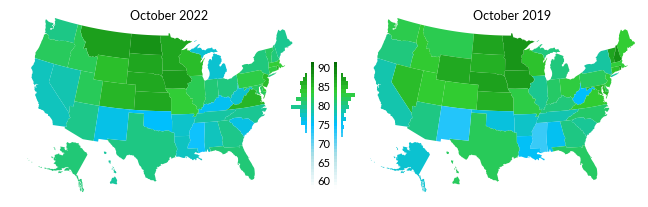

In [37]:
# Pre covid
pr = -37 if data.index[-1] >= pd.to_datetime('2022-03-01') else -25

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

colors = ["white", "powderblue", "deepskyblue", "limegreen", "darkgreen"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (pr, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_ABBR']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_ABBR'] == 'HI':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_ABBR'] == 'AK':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.97, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [60, 65, 70, 75, 80, 85, 90]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (pr, 0.44, 0.4)]:
    for i in np.linspace(58,92,40):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/35, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(58,92,33)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/33, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/pa_epop_map.pgf', bbox_inches='tight')

In [38]:
prtxt = 'three' if pr == -37 else 'two'
s = data.iloc[-1] - data.iloc[pr]
ltdt = dtxt(data.index[-1])['mon1']
prdt = dtxt(data.index[pr])['mon1']
groups = (s.agg(higher=lambda x: (x > 0).sum(),
                lower=lambda x: (x < 0).sum(),
                unchanged=lambda x: (x == 0).sum())
           .sort_values(ascending=False)
           .rename({'unchanged': 'the same'})) 
mainhl = groups.index[0]
v = groups.iloc[0]
mainn = numbers(f'{v:.1f}') if v < 10 else v
secondhl = ''
and1 = 'and ' if groups.iloc[2] == 0 else ''
if groups.iloc[1] > 0:
    v = groups.iloc[1]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    secondhl = f', {and1}{groups.index[1]} in {n} states'
thirdhl = ''
if groups.iloc[2] > 0:
    v = groups.iloc[2]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    thirdhl = f', and {groups.index[2]} in {n} states'
text = (f'The age 25 to 54 employment rate is {mainhl} in '+
        f'{ltdt} than it was in {prdt} in {mainn} states'+
        f'{secondhl}{thirdhl}. ')
sa = pd.read_csv(data_dir / 'state_pa_epop_sa_raw.csv', 
                   index_col='date', parse_dates=True)
s2 = sa.iloc[-3:].mean() - sa.iloc[-6:-3].mean()
grp = (s2.agg(increased=lambda x: (round(x, 1) > 0).sum(),
              decreased=lambda x: (round(x, 1) < 0).sum(),
              unchanged=lambda x: (round(x, 1) == 0).sum())
         .sort_values(ascending=False)
         .rename({'unchanged': 'was unchanged'})) 
mainhl = grp.index[0]
v = grp.iloc[0]
mainn = numbers(f'{v:.1f}') if v < 10 else v
secondhl = ''
and1 = 'and ' if grp.iloc[2] == 0 else ''
if grp.iloc[1] > 0:
    v = grp.iloc[1]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    secondhl = f', {and1}{grp.index[1]} in {n} states'
thirdhl = ''
if grp.iloc[2] > 0:
    v = grp.iloc[2]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    thirdhl = f', and {grp.index[2]} in {n} states'
txt1 = (f'{text}Comparing the latest three months to the '+
        'previous three months, the seasonally-adjusted age '+
        f'25 to 54 employment rate {mainhl} in {mainn} states'+
        f'{secondhl}{thirdhl}.')
write_txt(text_dir / 'state_pa_emp.txt', txt1)
print(txt1, '\n')

states = {i['STATE_ABBR']: i['STATE_NAME'] 
          for i in m.states_info}
top = data.iloc[-1].sort_values(ascending=False).iloc[:3]
topt = [f'{states[top.index[i]]} ({top.iloc[i]:.1f} percent)' 
        for i in [0, 1, 2]]
txt2 = (f'In {ltdt}, the states with the highest employment rates '+
        f'for 25 to 54 year olds are {topt[0]}, {topt[1]}, and '+
        f'{topt[2]}.')
write_txt(text_dir / 'state_pa_emp_t3.txt', txt2)
print(txt2)

The age 25 to 54 employment rate is lower in October 2022 than it was in October 2019 in 29 states, and higher in 22 states. Comparing the latest three months to the previous three months, the seasonally-adjusted age 25 to 54 employment rate decreased in 29 states, increased in 19 states, and was unchanged in three states. 

In October 2022, the states with the highest employment rates for 25 to 54 year olds are North Dakota (87.8 percent), Iowa (87.0 percent), and Montana (86.7 percent).
